In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from modules import create_model
from dataset import get_data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
x_train = get_data("/content/drive/My Drive/Colab Notebooks/COMP3710-report/dataset/train_data/")
x_train -= np.mean(x_train)
y_train = get_data("/content/drive/My Drive/Colab Notebooks/COMP3710-report/dataset/train_truth/",is_y=True)
x_validation = get_data("/content/drive/My Drive/Colab Notebooks/COMP3710-report/dataset/validation_data/")
x_validation -= np.mean(x_validation)
y_validation = get_data("/content/drive/My Drive/Colab Notebooks/COMP3710-report/dataset/validation_truth/",is_y=True)
Improved_unet = create_model()



Found 1051 files belonging to 1 classes.
ISIC-2017_Training_Data: loading finished
Found 1051 files belonging to 1 classes.
ISIC-2017_Training_Part1_GroundTruth: loading finished
Found 110 files belonging to 1 classes.
ISIC-2017_Validation_Data: loading finished
Found 110 files belonging to 1 classes.
ISIC-2017_Validation_Part1_GroundTruth: loading finished
Model build success


In [ ]:

# need improvement, should add a weight decay to LR, +
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=11,
    decay_rate=0.985
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


def dice_loss(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    numerator = 2 * tf.reduce_sum(y_true * y_pred) + 1e-6
    denominator = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-6
    
    return  1-numerator / denominator

# need a dice loss function
Improved_unet.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'],run_eagerly=True)

Improved_unet.fit(x_train, y_train,
                  batch_size=100,
                  epochs=300,
                  shuffle=True,
                  validation_data=(x_validation, y_validation),
                  steps_per_epoch=11
                  )



Epoch 1/300
11/11 [==============================] - 4s 388ms/step - loss: 0.6794 - accuracy: 0.6937 - val_loss: 0.6354 - val_accuracy: 0.7395
Epoch 2/300
11/11 [==============================] - 4s 385ms/step - loss: 0.5356 - accuracy: 0.8024 - val_loss: 0.3658 - val_accuracy: 0.8967
Epoch 3/300
11/11 [==============================] - 4s 387ms/step - loss: 0.4810 - accuracy: 0.8204 - val_loss: 0.4090 - val_accuracy: 0.8275
Epoch 4/300
11/11 [==============================] - 4s 384ms/step - loss: 0.3650 - accuracy: 0.8583 - val_loss: 0.3628 - val_accuracy: 0.8512
Epoch 5/300
11/11 [==============================] - 4s 386ms/step - loss: 0.3166 - accuracy: 0.8761 - val_loss: 0.3181 - val_accuracy: 0.8605
Epoch 6/300
11/11 [==============================] - 4s 383ms/step - loss: 0.2894 - accuracy: 0.8840 - val_loss: 0.2554 - val_accuracy: 0.8947
Epoch 7/300
11/11 [==============================] - 4s 384ms/step - loss: 0.2678 - accuracy: 0.8888 - val_loss: 0.2599 - val_accuracy: 0.9134

In [ ]:

x_test = get_data("/content/drive/My Drive/Colab Notebooks/COMP3710-report/dataset/test_data/")
output=Improved_unet.predict(x_test)

output=output[:,:,:,1:2,:]
output=np.squeeze(output)
output = np.insert(output, 2, 0, axis=3)

output = np.where(output > 0.5, float(1), float(0))

Found 219 files belonging to 1 classes.
ISIC-2017_Test_v2_Data: loading finished
7/7 [==============================] - 0s 46ms/step
[[[[9.99154449e-01 8.45586183e-04 0.00000000e+00]
   [9.99945760e-01 5.42408779e-05 0.00000000e+00]
   [9.99996185e-01 3.78329310e-06 0.00000000e+00]
   ...
   [9.99732435e-01 2.67496303e-04 0.00000000e+00]
   [9.98404920e-01 1.59504241e-03 0.00000000e+00]
   [9.88924921e-01 1.10750375e-02 0.00000000e+00]]

  [[9.99953747e-01 4.62245771e-05 0.00000000e+00]
   [9.99999762e-01 2.03600010e-07 0.00000000e+00]
   [1.00000000e+00 3.39539108e-09 0.00000000e+00]
   ...
   [9.99997973e-01 2.04994149e-06 0.00000000e+00]
   [9.99973655e-01 2.63743896e-05 0.00000000e+00]
   [9.98997509e-01 1.00246898e-03 0.00000000e+00]]

  [[9.99997497e-01 2.49434584e-06 0.00000000e+00]
   [1.00000000e+00 1.47419255e-09 0.00000000e+00]
   [1.00000000e+00 6.20288022e-12 0.00000000e+00]
   ...
   [1.00000000e+00 3.09370520e-08 0.00000000e+00]
   [9.99998927e-01 1.02991942e-06 0.000000

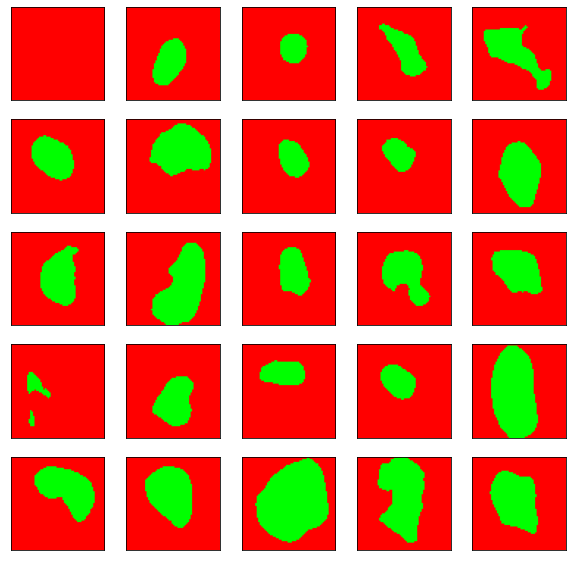

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(output[i])
plt.show()

calculate the dice similarity coeffient


In [ ]:
y_test=get_data("/content/drive/My Drive/Colab Notebooks/COMP3710-report/dataset/test_truth/",is_y=True)

y_test = y_test[:, :, :, 1:2, :]
y_test = np.squeeze(y_test)
y_test = np.insert(y_test, 2, 0, axis=3)
y_test = np.where(y_test > 0.5, float(1), float(0))
dice_similarity=1-dice_loss(output,y_test)
print(dice_similarity.numpy())

Found 219 files belonging to 1 classes.
ISIC-2017_Test_v2_Part1_GroundTruth: loading finished
0.8547709
